In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score

import tensorflow
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model

import tensorflow_addons as tfa

In [2]:
# plot confusion matrix
def plot_cm(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

# Evaluate model
def evaluate_model(y_true, y_pred, avg='macro'):
    auprc = average_precision_score(y_true, y_pred, average=avg)
    precision = precision_score(y_true, y_pred, average=avg)
    recall = recall_score(y_true, y_pred, average=avg)
    f1_sc = f1_score(y_true, y_pred, average=avg)
    
    metrics_lst = ['AUCPRC','precision','recall','f1 score']
    metrics_vals = [auprc, precision, recall, f1_sc]
    for i in range(len(metrics_vals)):
        print(f'{metrics_lst[i]}: {metrics_vals[i]}')

In [3]:
df = pd.read_csv('no_supervised_df.csv').set_index('BELNR')
df.head()

,DMBTR,WRBTR,label,HKONT_A42,HKONT_B1,HKONT_B2,HKONT_B3,HKONT_B35,HKONT_C25,HKONT_C42,...,HKONT_V78,HKONT_V92,HKONT_W03,HKONT_W12,HKONT_W62,HKONT_X53,HKONT_Y03,HKONT_Y23,HKONT_Z01,HKONT_Z02
BELNR,,,,,,,,,,,,,,,,,,,,,
288203,280979.60,0.00,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324441,129856.53,243343.00,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
133537,957463.97,3183838.41,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
331521,2681709.51,28778.00,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
375333,910514.49,346.00,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train_df = df[df['label']==0]
anomalies_df = df[df['label']==1]

In [5]:
df_without_outliers = train_df[['DMBTR','WRBTR']].copy()

Q1 = train_df[['DMBTR','WRBTR']].quantile(0.25)
Q3 = train_df[['DMBTR','WRBTR']].quantile(0.75)
IQR = Q3 - Q1

lower_vals = (df_without_outliers < (Q1 - (1.5 * IQR)))
upper_vals = (df_without_outliers > (Q3 + (1.5 * IQR)))

df_without_outliers = df_without_outliers.mask(lower_vals, Q1, axis=1)
df_without_outliers = df_without_outliers.mask(upper_vals, Q3, axis=1)
df_without_outliers.shape

(532586, 2)

In [6]:
train_df = train_df.drop(['DMBTR','WRBTR'], axis=1)
train_df = train_df.join(df_without_outliers, on='BELNR')

In [7]:
y = train_df['label']
X = train_df.drop('label', axis=1)

X_anomalies = anomalies_df.drop('label', axis=1)
y_anomalies = anomalies_df['label']

In [8]:
seed=42
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, 
                                                                    y,
                                                                    test_size=0.3, 
                                                                    random_state=seed)

X_val, X_test_, y_val, y_test_ = train_test_split(X_test_and_val,
                                                y_test_and_val,
                                                test_size=0.5,
                                                random_state=seed)

In [9]:
X_test = pd.concat([X_test_, X_anomalies])
y_test = pd.concat([y_test_, y_anomalies])

In [10]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [11]:
input_img = keras.Input(shape=(X_train.shape[1]))
encoded = layers.Dense(512, activation='relu')(input_img)
encoded = layers.Dense(256, activation='relu')(encoded)
encoded = layers.Dense(64, activation='relu')(encoded)

decoded = layers.Dense(256, activation='relu')(encoded)
decoded = layers.Dense(512, activation='relu')(decoded)
decoded = layers.Dense(X_train.shape[1], activation='sigmoid')(decoded)

autoencoder = keras.Model(input_img, decoded)

Metal device set to: Apple M1


2022-08-07 23:11:24.486686: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-07 23:11:24.486839: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


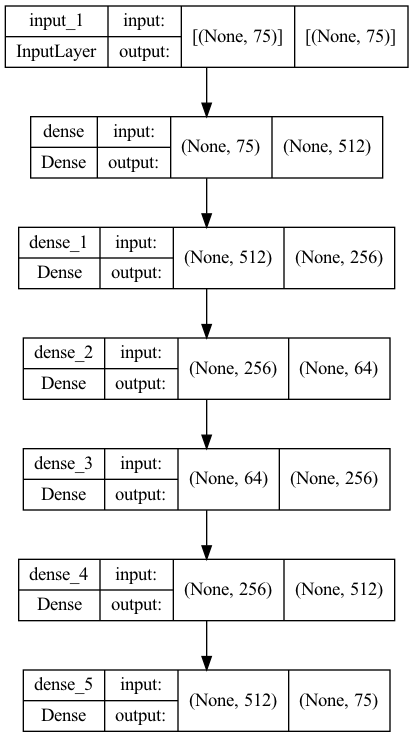

In [12]:
plot_model(autoencoder, show_shapes=True)

In [13]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",
                                        mode ="min", 
                                        patience = 10, 
                                        restore_best_weights=True)

In [14]:
autoencoder.compile(optimizer=SGD(momentum=0.7), 
                  loss='mse')

In [15]:
history = autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=256,
                callbacks=[earlystopping],
                validation_data=(X_val, X_val))

Epoch 1/100


2022-08-07 23:11:25.115872: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


   5/1457 [..............................] - ETA: 20s - loss: 0.2466  

2022-08-07 23:11:25.446872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1457/1457 [==============================] - ETA: 0s - loss: 0.1297

2022-08-07 23:11:47.571820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1457/1457 [==============================] - 26s 17ms/step - loss: 0.1297 - val_loss: 0.0100
Epoch 2/100
1457/1457 [==============================] - 25s 17ms/step - loss: 0.0087 - val_loss: 0.0083
Epoch 3/100
1457/1457 [==============================] - 24s 17ms/step - loss: 0.0081 - val_loss: 0.0080
Epoch 4/100
1457/1457 [==============================] - 27s 19ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 5/100
1457/1457 [==============================] - 30s 21ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 6/100
1457/1457 [==============================] - 36s 24ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 7/100
1457/1457 [==============================] - 38s 26ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 8/100
1457/1457 [==============================] - 39s 27ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 9/100
1457/1457 [==============================] - 32s 22ms/step - loss: 0.0057 - val_loss: 0.0053
Epoch 10/100
1457/1457 [==============================] - 29s 20ms/

Epoch 78/100
1457/1457 [==============================] - 11s 8ms/step - loss: 6.8328e-04 - val_loss: 6.7405e-04
Epoch 79/100
1457/1457 [==============================] - 11s 8ms/step - loss: 6.5604e-04 - val_loss: 6.4725e-04
Epoch 80/100
1457/1457 [==============================] - 11s 8ms/step - loss: 6.2961e-04 - val_loss: 6.2108e-04
Epoch 81/100
1457/1457 [==============================] - 11s 8ms/step - loss: 6.0332e-04 - val_loss: 5.9496e-04
Epoch 82/100
1457/1457 [==============================] - 11s 8ms/step - loss: 5.7797e-04 - val_loss: 5.6971e-04
Epoch 83/100
1457/1457 [==============================] - 11s 8ms/step - loss: 5.5298e-04 - val_loss: 5.4473e-04
Epoch 84/100
1457/1457 [==============================] - 11s 7ms/step - loss: 5.2770e-04 - val_loss: 5.1943e-04
Epoch 85/100
1457/1457 [==============================] - 11s 8ms/step - loss: 5.0276e-04 - val_loss: 4.9425e-04
Epoch 86/100
1457/1457 [==============================] - 11s 8ms/step - loss: 4.7799e-04 - val_

In [16]:
X_train_pred = autoencoder.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

2022-08-07 23:47:14.063352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


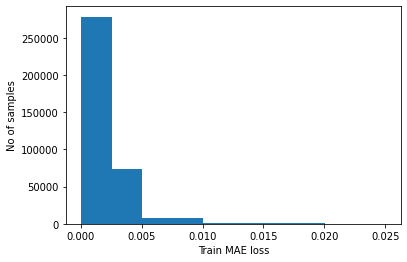

Error threshold:  0.025024501651566635


In [17]:
plt.hist(train_mae_loss)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

threshold = np.max(train_mae_loss)
print("Error threshold: ", threshold)

In [18]:
X_test_pred = autoencoder.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

In [19]:
anomalies = test_mae_loss > threshold
y_pred = np.where(test_mae_loss > threshold, 1, 0)

print("Number of abnormal samples: ", np.sum(anomalies))

Number of abnormal samples:  70


In [20]:
evaluate_model(y_test, y_pred)

AUCPRC: 0.7003750562584388
precision: 0.9998123076153057
recall: 0.85
f1 score: 0.9116708420724835


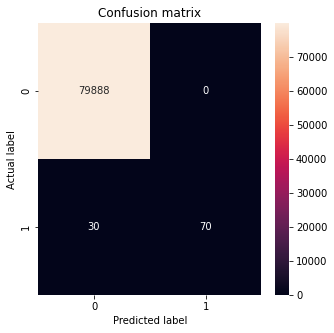

In [21]:
plot_cm(y_test, y_pred)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


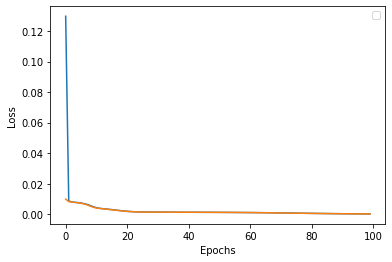

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()